In [4]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import pickle

import matplotlib.patches as patches
import matplotlib as mpl
import json
warnings.filterwarnings('ignore')

In [5]:
canvasWidth = 1000 
canvasHeight = 600
ball_Xs = [322.3, 322.3, 322.3, 322.3, 500 , 500 , 500 , 500 , 604.4, 604.4, 604.4, 604.4]
color_map = plt.get_cmap('viridis', 6)
green = color_map(4)
modeling_choice = 'Model_both_x_and_y'

In [6]:
choice_order = ["gt", "mid", "lp"]
# Define fixed color palettes
time_limit_palette = {'700.0': "#d6604d", '3000.0': "#f4a582"} 
choice_palette = {"gt": "#b2df8a", "mid": "#1f78b4", "lp": "#a6cee3"}  
response_palette = {"f": "#e08214", "j": "#8073ac"}

# Define colors for different elements
ground_truth_color = 'cyan'
model_prediction_color = 'darkblue'
# human_centroid_color = 'gray'
human_centroid_color = '#0A704E'
participant_color = green 
# participant_color = 'blueviolet'
screen_color = 'lightgray'
ball_color = '#ececd1'
# anchor_color = '#f59f01'
# anchor_color = '#0A704E' # dark_green
anchor_color = 'darkviolet'

# choice_edge_color = {'gt': "#b2df8a",
#        'lp': "#a6cee3",
#        'mid': "#1f78b4"}
choice_edge_color = {'gt': ground_truth_color,
       'lp': '#5fa55a',
       'mid': 'blueviolet'}

In [7]:
# For the binomial test:
try:
    from scipy.stats import binomtest  # SciPy >= 1.7
except ImportError:
    from scipy.stats import binom_test
    def binomtest(k, n, p=0.5):
        return type("BinomTestResult", (), {"pvalue": binom_test(k, n, p)})()

def plot_grouped_stacked_bar(data, alpha=0.05):
    sns.set_theme(style="whitegrid", context="talk")  # Use a clean theme

    # Drop missing responses
    data = data.dropna(subset=['response'])
    data['choice'] = pd.Categorical(data['choice'], categories=choice_order, ordered=True)
    
    # Prepare data for grouped stacked bar plot
    grouped_data = (
        data.groupby(['choice', 'timeLimit', 'response'])
        .size()
        .reset_index(name='count')  # Count occurrences
    )

    # Calculate percentages
    grouped_data['total'] = grouped_data.groupby(['choice', 'timeLimit'])['count'].transform('sum')
    grouped_data['percentage'] = 100 * grouped_data['count'] / grouped_data['total']

    # Create subplots for each choice
    choices = sorted(data['choice'].unique())
    fig, axs = plt.subplots(1, len(choices), figsize=(8, 6), sharey=True, constrained_layout=True)

    for i, choice in enumerate(choice_order):
        # If there's only one choice, axs is not an array
        ax = axs[i] if len(choices) > 1 else axs

        subset = grouped_data[grouped_data['choice'] == choice]

        # Pivot the data for stacking (percentages)
        pivot_data = subset.pivot(index='timeLimit', columns='response', values='percentage').fillna(0)
        # Reorder columns to ensure `j` is at the bottom
        pivot_data = pivot_data[['j', 'f']]

        # --- Get the count data for binomial test ---
        pivot_counts = subset.pivot(index='timeLimit', columns='response', values='count').fillna(0)
        # Ensure same column order ['j','f']
        for col in ['j', 'f']:
            if col not in pivot_counts.columns:
                pivot_counts[col] = 0
        pivot_counts = pivot_counts[['j','f']]

        # Plot stacked bars (original code)
        pivot_data.plot(
            kind='bar',
            stacked=True,
            ax=ax,
            color=[response_palette['j'], response_palette['f']],  # if you have a predefined palette
            legend=False,
            alpha=0.8,
            width=0.55
        )
        ax.set_title(f"{choice}", fontsize=16)
        ax.set_xlabel("")
        ax.set_ylabel("Percentage" if i == 0 else "", fontsize=18)
        ax.set_ylim(0, 110)  # Set y-axis to 0-100 for percentages
        ax.axhline(y=50, linewidth=2, color="black", ls=":")

        # Rotate x-axis labels to horizontal
        ax.tick_params(axis='x', labelrotation=0)

        # -------------------------------------------------
        # Perform binomial tests and add stars when p < alpha
        # -------------------------------------------------
        # We'll test if the proportion of 'j' differs from 0.5 in each timeLimit
        # for this particular choice.
        for bar_index, time_lim in enumerate(pivot_data.index):
            n_j = pivot_counts.loc[time_lim, 'j']
            n_f = pivot_counts.loc[time_lim, 'f']
            n_total = n_j + n_f

            if n_total > 0:
                result = binomtest(n_j, n_total, p=0.5)
                if result.pvalue < alpha:
                    # We place a star above the stacked bar
                    # Get the top of the bar (j% + f%)
                    y_j = pivot_data.loc[time_lim, 'j']   # stacked height of 'j'
                    y_f = pivot_data.loc[time_lim, 'f']   # stacked height of 'f'
                    top_height = y_j + y_f

                    ax.text(
                        bar_index,             # x-position at the bar index
                        top_height + 5,        # y-position slightly above
                        "*",
                        ha='center',
                        va='bottom',
                        fontsize=16,
                        color='red',
                        fontweight='bold'
                    )

    # Add a global title
    plt.suptitle("Percentage of Responses ('f' and 'j') by Probe Type and Time Limit", fontsize=18)

    # Add legend for the last subplot
    if len(choices) > 1:
        handles, labels = axs[-1].get_legend_handles_labels()
    else:
        handles, labels = axs.get_legend_handles_labels()

    fig.legend(handles, labels, title="Response", loc="upper center",
               bbox_to_anchor=(0.5, -0.05), ncol=2)
    plt.show()

    return grouped_data

In [8]:
df_all = pd.read_csv('../sanityCheck_rawData/df_all_pilot_v2_19participants.csv')
df_all['is_accurate'] = df_all['is_accurate'].astype('boolean')
df_all['choice'] = pd.Categorical(df_all['choice'], categories=choice_order, ordered=True)

# drops na after calculating missing rates
df_all = df_all.dropna(subset=['response'])

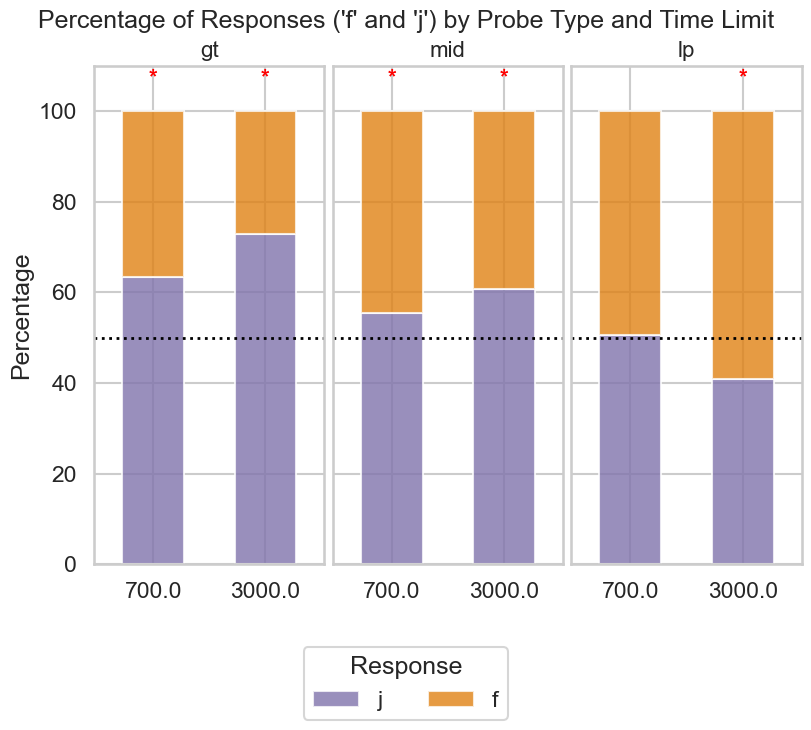

In [9]:
grouped_data = plot_grouped_stacked_bar(df_all)

In [10]:
grouped_data = (
        df_all.groupby(['stimulus_idx', 'choice', 'response'])
        .size()
        .reset_index(name='count')  # Count occurrences
    )

# Calculate percentages
grouped_data['total'] = grouped_data.groupby(['stimulus_idx', 'choice'])['count'].transform('sum')
grouped_data['percentage'] = 100 * grouped_data['count'] / grouped_data['total']
grouped_data_j = grouped_data[grouped_data['response'] == 'j'].copy()

### Fig 1: set up with trajectories and choices, and the percentage of j's for choices

In [128]:
# canvas settings
segmented_line = [((250, 150), (250, 450)), ((250, 450), (750, 450)), ((750, 450), (750, 150))]
top_y = 150
bottom_y = 450
left_x = 150
right_x = 750
ball_radius = 30
obstacle_radius = 45
positions = np.sort(df_all['stimulus_idx'].unique())
fall_Direction = {1.0: 'left', 2.0: 'right', 3.0: 'right', 4.0: 'left', 
                 5.0: 'right', 6.0: 'right', 7.0: 'left', 8.0: 'left',
                 9.0: 'left', 10.0: 'right', 11.0: 'left', 12.0: 'right'}
# width of the blue region
l = ball_radius + 3**0.5/2*obstacle_radius

# x_range for stimulus_idx in positions for obstacle_idx in anchors
x_blue_range = {}

for stimulus_idx in positions:
    direction = fall_Direction[stimulus_idx]
    x_ball = ball_Xs[int(stimulus_idx)-1]
    # To make sure the edges of the blue region are exclusive (also to ensure valid collision), 
    # a tiny margin of 1 is applied. E.g. (150, 350) -> [149, 349].
    margin = 1
    # if the ball is falling towards the left
    # x_min = x_ball + adjustment
    # x_max = x_ball + l - adjustment, (otherwise, when x = x_ball + l, no collision would happen)
    if direction == 'left':
        range_vals = (x_ball + margin, x_ball + l - margin)
    else:
        range_vals = (x_ball - l + margin, x_ball - margin)
        
    x_blue_range[stimulus_idx] = range_vals

In [129]:
def drawTrueTrajectory(condition, df, ax, zorder, color):
    subset = df[df['stimulus_idx'] == condition]
    trails = subset['exact_path_single']
    data_list = subset['exact_path_single'].iloc[0]
    x_coords = [item[0] for item in data_list]
    y_coords = [item[1] for item in data_list]
    ax.plot(x_coords, y_coords, '-', color=color, linewidth=2, zorder=zorder)

def drawSimulatedTrajectory(condition, ax, jsonFilePath, zorder, color):
    with open(jsonFilePath, 'r') as file:
        data = json.load(file)

    # Convert data to DataFrame
    df = pd.json_normalize(data)
    subset = df[df['stimulus_idx'] == condition]
    data_list = subset['simulated_trial'].iloc[0]
    x_coords = [item[0] for item in data_list]
    y_coords = [item[1] for item in data_list]
    ax.plot(x_coords, y_coords, '-', color=color, linewidth=2, zorder=zorder)

In [130]:
df_exp1 = pd.read_pickle('../../../Model Fitting/allData_Sep_29.pkl')

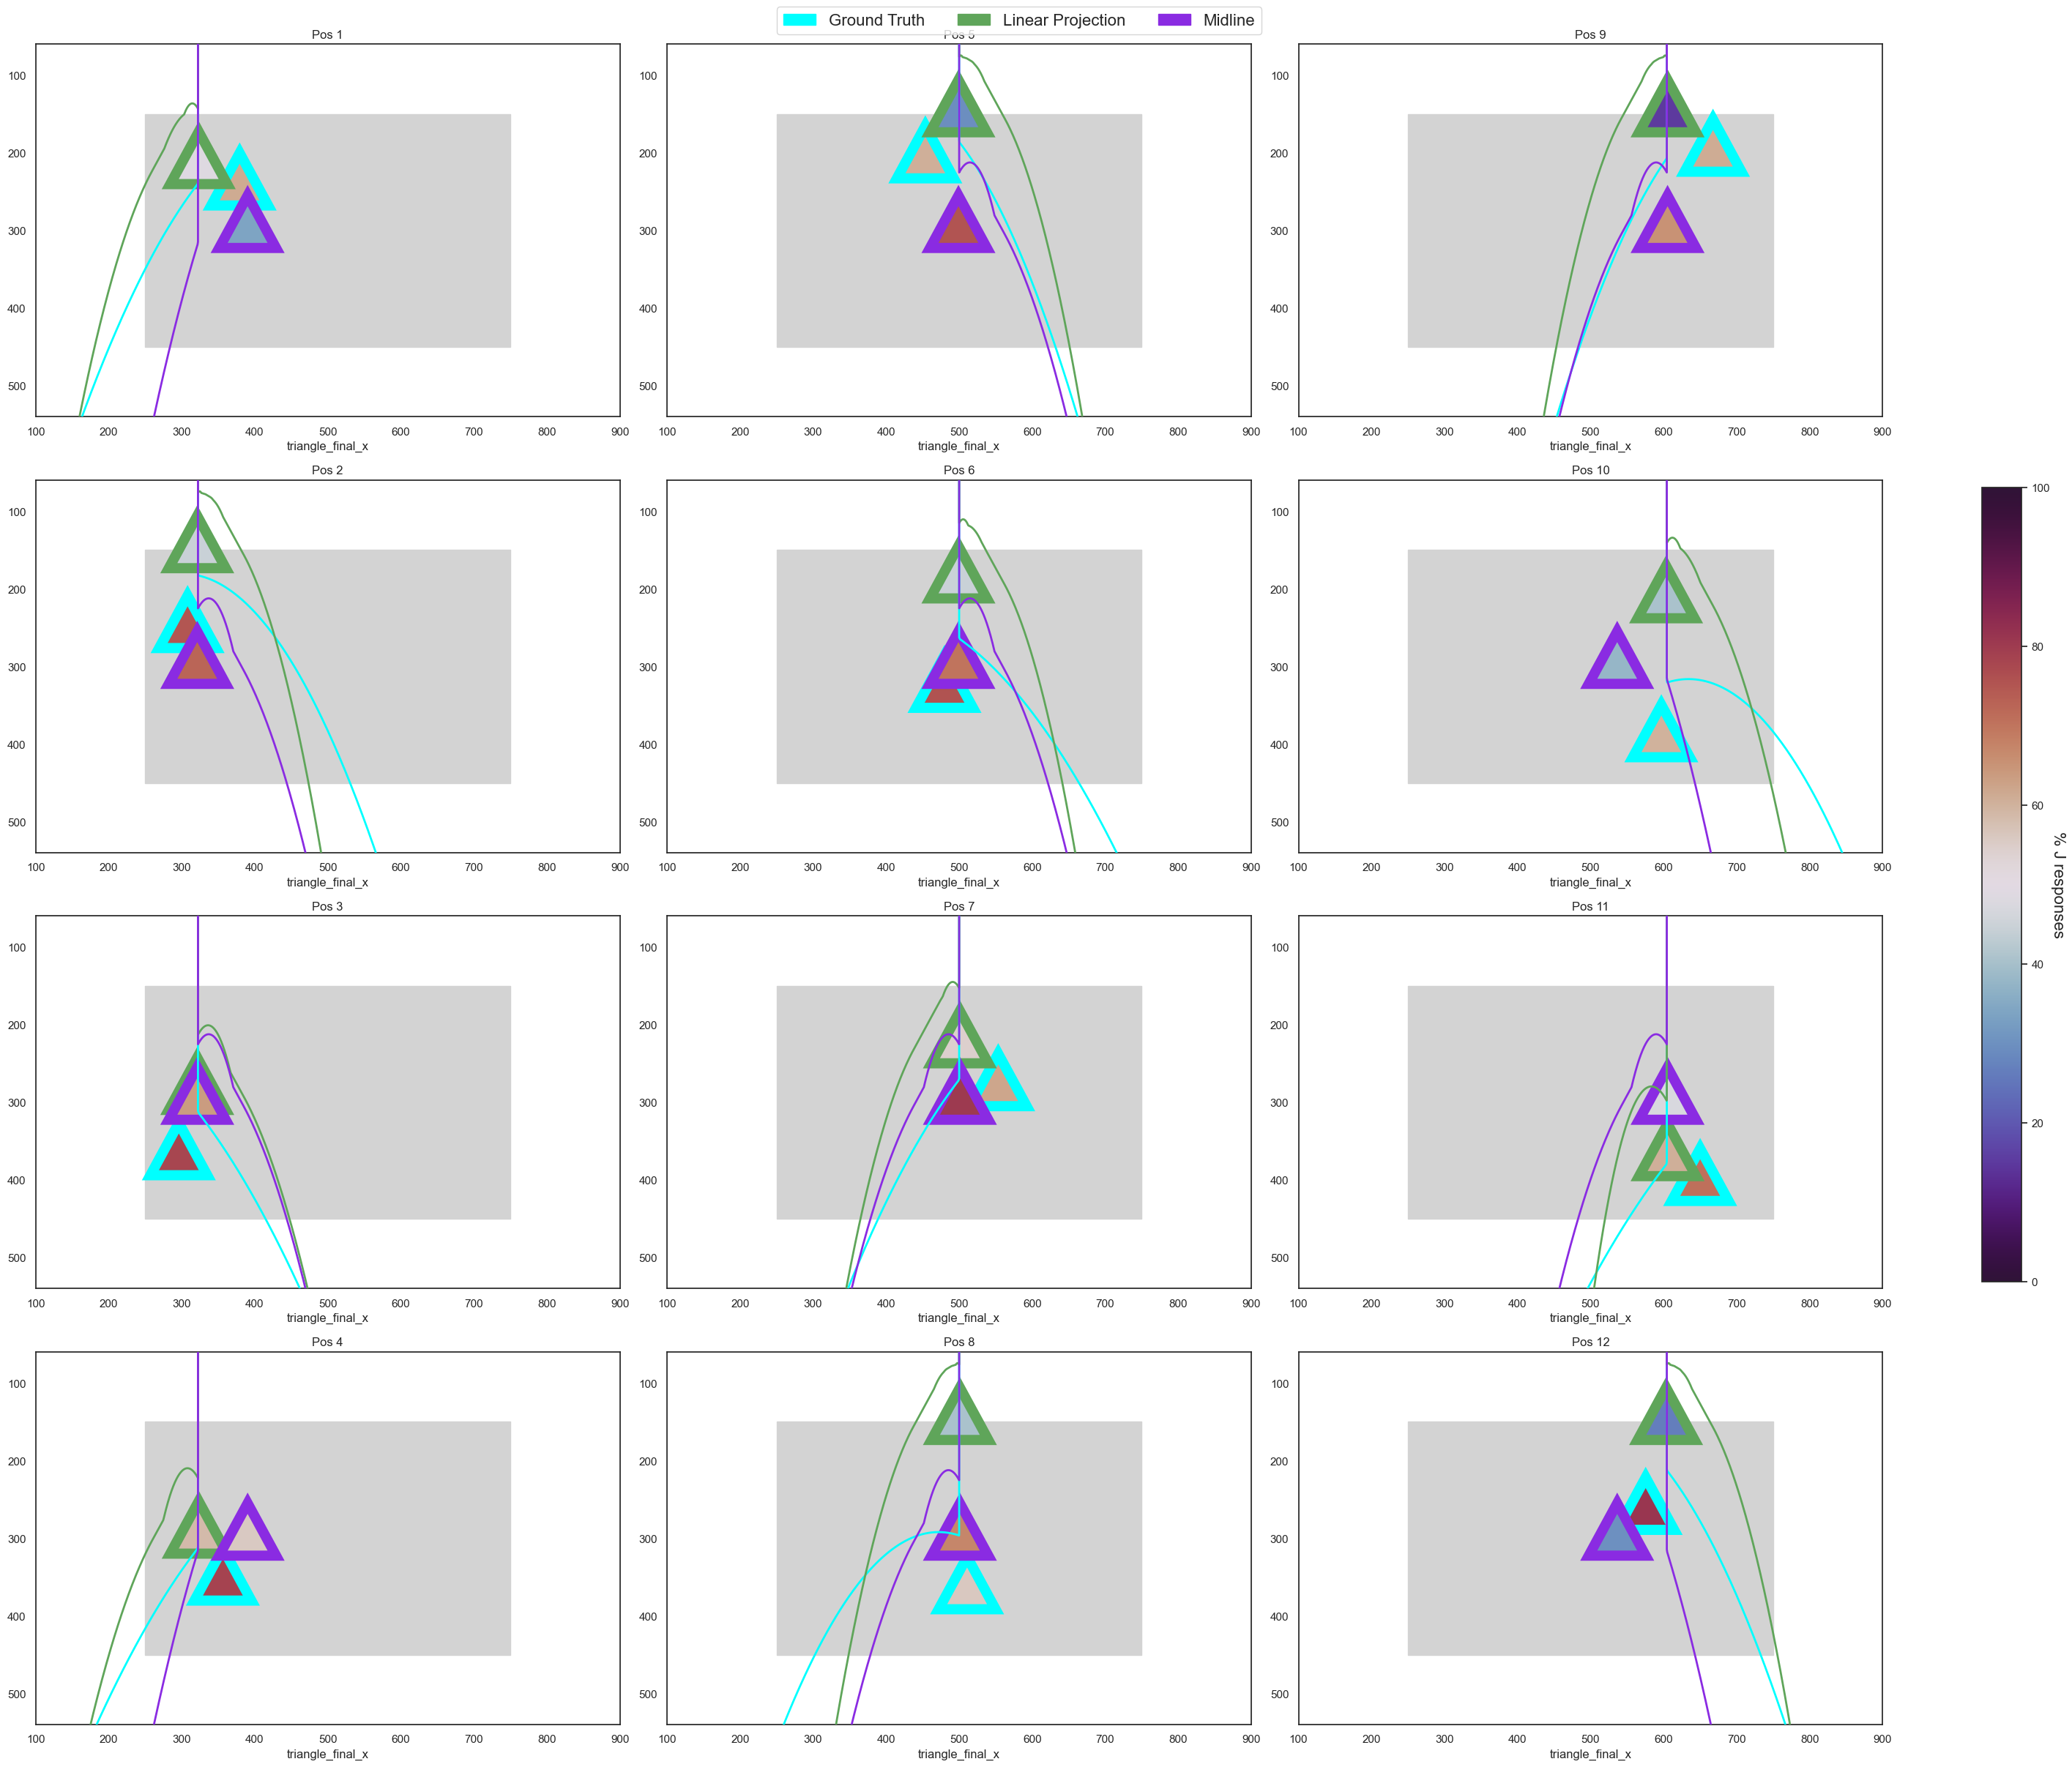

In [131]:
# load choices from stored output
def loadInits(modelName):
    with open(f'../../../Model Fitting/runSimulation/full72Trajectories/{modeling_choice}/{modelName}/x_coords_{modelName}.pkl', 'rb') as f:
            x_coords = pickle.load(f)
    with open(f'../../../Model Fitting/runSimulation/full72Trajectories/{modeling_choice}/{modelName}/y_coords_{modelName}.pkl', 'rb') as f:
            y_coords = pickle.load(f)
    return x_coords, y_coords
x_lp_all, y_lp_all = loadInits('LP_near')
x_mid_all, y_mid_all = loadInits('Midline')

# Reshape positions into a 3x4 array and flatten by column
positions = np.sort(df_all['stimulus_idx'].unique())
positions = positions.reshape((3, 4)).T.flatten()

sns.set_theme(style="white")

cmap = plt.get_cmap('twilight_shifted')  # e.g. a built-in orange gradient
norm = mpl.colors.Normalize(vmin=0, vmax=100)  # 0% to 100%

fig, axs = plt.subplots(4, 3, figsize=(28, 24)) # Creates a 4x3 grid of Axes objects

# Empty lists to hold all handles and labels
handles, labels = [], []

for index, position in enumerate(positions):
    ax = axs.flatten()[index]  # Select the current Axes object

    # Draw triangle and rectangle
    x_gt = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_x'].values[0]
    y_gt = df_all.loc[df_all['stimulus_idx'] == position, 'obstacle_groundTruth_y'].values[0]
    x_lp, y_lp = x_lp_all[int(position-1)*6], y_lp_all[int(position-1)*6]
    x_mid, y_mid = x_mid_all[int(position-1)*6], y_mid_all[int(position-1)*6]
    x_coord_ball = df_all.loc[df_all['stimulus_idx'] == position, 'ball_X'].values[0]
    y_coord_ball = 100

    choice_info = [
       ('gt', (x_gt, y_gt)),
       ('lp', (x_lp, y_lp)),
       ('mid', (x_mid, y_mid))
    ]

    # ball = patches.Circle((x_coord_ball, y_coord_ball), radius = 30, color = '#ececd1')
    rect = patches.Rectangle((250,150),500,300,linewidth=1, edgecolor='lightgray',facecolor='lightgray') # occluder
    # blue region
    # blue_region = patches.Rectangle((x_blue_range[position][0],150),x_blue_range[position][1]-x_blue_range[position][0],300,linewidth=1, edgecolor='lightblue',facecolor='lightblue', alpha = 0.5) 
    # ax.add_patch(ball)
    ax.add_patch(rect)
    # ax.add_patch(blue_region)

    for ch_name, (xc, yc) in choice_info:
        subset = grouped_data_j[(grouped_data_j['stimulus_idx'] == position) & (grouped_data_j['choice'] == ch_name)]
        pct_j = subset['percentage'].values[0]
        fill_color = cmap(norm(pct_j))  
        edge_color = choice_edge_color[ch_name]
        
        # 4) Draw the triangle
        tri = patches.RegularPolygon(
            (xc, yc),
            orientation=np.pi,  # rotate if needed
            numVertices=3,
            radius=45,
            edgecolor=edge_color,  
            facecolor=fill_color,
            fill=True,
            linewidth=10,
            label=ch_name
        )
        ax.add_patch(tri)
    
    # plot the true trajectory
    drawTrueTrajectory(position, df_exp1, ax, 7, choice_edge_color['gt'])
    
    # plot the simulated path
    drawSimulatedTrajectory(position, ax, f'../../../Model Fitting/runSimulation/full72Trajectories/{modeling_choice}/LP_near/all72_results.json', 7, choice_edge_color['lp'])
    drawSimulatedTrajectory(position, ax, f'../../../Model Fitting/runSimulation/full72Trajectories/{modeling_choice}/Midline/all72_results.json', 7, choice_edge_color['mid'])

    ax.set_xlim(100, 900)
    ax.set_ylim(60, 540)
    ax.invert_yaxis() # invert the y-axis
    ax.set_xlabel("triangle_final_x")
    ax.set_title(f'Pos {int(position)}')
    
plt.tight_layout()  
# Add a single global legend
handles = [
    patches.Patch(color=choice_edge_color['gt'], label='Ground Truth'),
    patches.Patch(color=choice_edge_color['lp'], label='Linear Projection'),
    patches.Patch(color=choice_edge_color['mid'], label='Midline')
]
fig.legend(handles=handles, loc='upper center', bbox_to_anchor=(0.5, 1.01), ncol=5, fontsize='16')

# 4) At the end of plotting, create a colorbar
sm = mpl.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
cbar = plt.colorbar(sm, ax=axs.ravel().tolist(), fraction=0.02, pad=0.05)
cbar.set_label('% J responses', fontsize = 16, rotation=270, labelpad=15)

plt.show()

### Fig 2: scatter plot - proportion of pressing j and distance between lp/mid vs. gt (lp, mid, gt different colors; 3000, 1000 different color transparencies)

In [132]:
# Count how many "j" vs. total responses per (stimulus,choice,time)
grouped_resp = (
    df_all
    .groupby(['stimulus_idx', 'choice', 'timeLimit', 'response'])
    .size()
    .reset_index(name='count')
)

# Within each (stimulus_idx, choice, time_cond) group, compute percentage
grouped_resp['total'] = grouped_resp.groupby(
    ['stimulus_idx', 'choice', 'timeLimit']
)['count'].transform('sum')

grouped_resp['prop'] = grouped_resp['count'] / grouped_resp['total']

# Filter for just "j"
df_prop_j = grouped_resp[grouped_resp['response'] == 'j'].copy()
df_prop_j.rename(columns={'prop': 'prop_j'}, inplace=True)

# Now df_prop_j has columns:
#   stimulus_idx, choice, timeLimit, response=j, count, total, prop_j

# Example aggregator: assume each row in df_all for a given (stimulus_idx, choice) 
# always has the same final_x, final_y. 
df_positions = (
    df_all
    .groupby(['stimulus_idx', 'choice', 'timeLimit'])
    .agg({
        'obstacle_choice_x': 'first',  
        'obstacle_choice_y': 'first',
        'obstacle_groundTruth_x': 'first',
        'obstacle_groundTruth_y': 'first',
    })
    .reset_index()
)

df_positions['dist_from_gt'] = np.sqrt(
    (df_positions['obstacle_choice_x'] - df_positions['obstacle_groundTruth_x']) ** 2 
  + (df_positions['obstacle_choice_y'] - df_positions['obstacle_groundTruth_y']) ** 2
)

df_plot = pd.merge(
    df_prop_j,
    df_positions,
    on=['stimulus_idx', 'choice', 'timeLimit'],  
    how='inner'
)

# Now df_plot has columns:
#   stimulus_idx, choice, time_cond, prop_j, final_x, final_y, dist_from_gt, ...

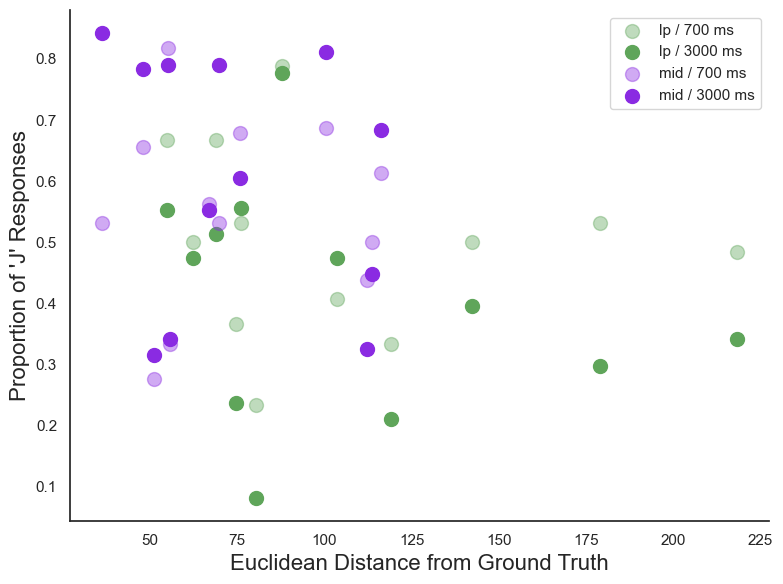

In [133]:
sns.set_theme(style="white")
fig, ax = plt.subplots(figsize=(8, 6))

alpha_map = {
    700: 0.4,
    3000: 1.0
}

for ch in ['lp', 'mid']:
    # Extract just this choice
    df_sub = df_plot[df_plot['choice'] == ch]
    
    for tcond in [700, 3000]:
        df_sub_t = df_sub[df_sub['timeLimit'] == tcond]
        # If there's no data for that combo, skip
        if df_sub_t.empty:
            continue
        
        ax.scatter(
            df_sub_t['dist_from_gt'],
            df_sub_t['prop_j'],
            color=choice_edge_color[ch],
            alpha=alpha_map[tcond],
            s=100,                        # marker size
            label=f"{ch} / {tcond} ms"
        )

# Optionally, if you want a single legend entry per choice rather than 
# separate for each time, you can do some trick with custom legend handles.
# But for a quick approach, let matplotlib auto-generate the legend:

ax.legend()
ax.set_xlabel("Euclidean Distance from Ground Truth", fontsize=16)
ax.set_ylabel("Proportion of 'J' Responses", fontsize=16)
# ax.set_title("Scatter: Distance vs. Proportion J")

sns.despine()
plt.tight_layout()
plt.show()

### Fig 3: scatter plot - proportion of pressing j and trajectory difference between lp/mid vs. gt (lp, mid, gt different colors; 3000, 1000 different color transparencies)

In [161]:
from similaritymeasures import frechet_dist

# select all points that are outside of the screen
# return list1, list2
# list1: list of points that form the path before the ball enters the screen (when ball_y <= top_y + ball_radius)
# list2: list of points that form the path before the ball exits the screen (when ball_y >= bottom_y - ball_radius or ball_x <= left_x + ball_radius or ball_x >= right_x - ball_radius)
def pickPointsOutScreen(path, top_y, bottom_y, left_x, right_x, ball_radius, keepSpeed = False):
    list1 = []
    list2 = []
    if len(path[0])==3:
        for ball_x,ball_y,speed in path:
            if ball_y <= top_y + ball_radius:
                if keepSpeed:
                    list1.append((ball_x,ball_y,speed))
                else:
                    list1.append((ball_x,ball_y))
            if (ball_y >= bottom_y - ball_radius) or (ball_x <= left_x + ball_radius) or (ball_x >= right_x - ball_radius):
                if keepSpeed:
                    list2.append((ball_x,ball_y,speed))
                else:
                    list2.append((ball_x,ball_y))
    else: 
        for ball_x,ball_y in path:
            if ball_y <= top_y + ball_radius:
                list1.append((ball_x,ball_y))
            if (ball_y >= bottom_y - ball_radius) or (ball_x <= left_x + ball_radius) or (ball_x >= right_x - ball_radius):
                list2.append((ball_x,ball_y))
    return list1, list2

# calculate Fréchet distance between list1_participant and list1_groundTruth (fd1) and list2_participant and list2_groundTruth (fd2)
# return fd1, fd2
def evaluateResponseByFD(rowData):
    simulatedPath = rowData['simulated_path']
    exactPath = rowData['exact_path_single']
    l1_p, l2_p = pickPointsOutScreen(simulatedPath, top_y, bottom_y, left_x, right_x, ball_radius)
    l1_g, l2_g = pickPointsOutScreen(exactPath, top_y, bottom_y, left_x, right_x, ball_radius)
    fd1 = frechet_dist(l1_p, l1_g)
    fd2 = frechet_dist(l2_p, l2_g)
    return fd1, fd2

In [162]:
# 1) Load LP_near data
with open(f'../../../Model Fitting/runSimulation/full72Trajectories/{modeling_choice}/LP_near/all72_results.json', 'r') as file:
    data_lp = json.load(file)
df_lp = pd.json_normalize(data_lp)  
# Typically, df_lp might have columns: ['stimulus_idx', 'simulated_trial', ...]

df_lp['choice'] = 'lp'  # Tag these rows as LP

# 2) Load Midline data
with open(f'../../../Model Fitting/runSimulation/full72Trajectories/{modeling_choice}/Midline/all72_results.json', 'r') as file:
    data_mid = json.load(file)
df_mid = pd.json_normalize(data_mid)

df_mid['choice'] = 'mid'  # Tag these rows as Midline

# 3) Combine them
df_sims = pd.concat([df_lp, df_mid], ignore_index=True)

# A) In your df_sims, if you truly only need 1 row per (stimulus_idx, choice),
#    you can group or drop duplicates:
df_sims_unique = (
    df_sims
    .drop_duplicates(subset=['stimulus_idx', 'choice'])  # keep='first' by default
    .reset_index(drop=True)
)

# B) If df_exp1 also has multiple rows for the same 'stimulus_idx',
#    but the same 'exact_path_single' repeated, drop duplicates there too:
df_exp1_unique = (
    df_exp1
    .drop_duplicates(subset=['stimulus_idx'])
    .reset_index(drop=True)
)

# Then merge:
df_merge = pd.merge(
    df_sims_unique,
    df_exp1_unique[['stimulus_idx', 'exact_path_single']],
    on='stimulus_idx',
    how='inner'
)

df_merge = df_merge.rename(columns={"simulated_trial": "simulated_path"})

In [163]:
evals_fd = df_merge.apply(evaluateResponseByFD, axis=1)
# expand the tuple into columns
df_merge[['fd1_enter', 'fd2_exit']] = pd.DataFrame(evals_fd.tolist(), index=df_merge.index)
df_merge['fd_sum'] = df_merge['fd1_enter'] + df_merge['fd2_exit']

In [164]:
# Suppose df_merge also has a 'timeLimit' column (if not, you'll need to add it 
# or compute it from df_all). Then you can do:

df_plot = pd.merge(
    df_merge, 
    df_prop_j,  
    on=['stimulus_idx', 'choice'], 
    how='inner'
)

# Now df_plot has columns:
#   stimulus_idx, choice, timeLimit, simulated_trial, exact_path_single, frechet_dist, prop_j, ...

In [156]:
df_plot

,stimulus_idx,obstacle_idx,ball_X,obstacle_X,obstacle_Y,simulated_path,choice,exact_path_single,fd1_enter,fd2_exit,fd_sum,timeLimit,response,count,total,prop_j
0,8,3,500.0,501.000000,151.000000,"[[320.859269148194, 599.9947954533251], [321.6...",lp,"[(236.29956860308448, 597.7702931052473, 13.92...",7.462988e+01,84.588955,159.218838,1000.0,j,14,44,0.318182
1,8,3,500.0,501.000000,151.000000,"[[320.859269148194, 599.9947954533251], [321.6...",lp,"[(236.29956860308448, 597.7702931052473, 13.92...",7.462988e+01,84.588955,159.218838,3000.0,j,18,49,0.367347
2,8,3,500.0,501.000000,300.000000,"[[338.08892890881344, 598.6216853236664], [339...",mid,"[(236.29956860308448, 597.7702931052473, 13.92...",0.000000e+00,101.792921,101.792921,1000.0,j,34,48,0.708333
3,8,3,500.0,501.000000,300.000000,"[[338.08892890881344, 598.6216853236664], [339...",mid,"[(236.29956860308448, 597.7702931052473, 13.92...",0.000000e+00,101.792921,101.792921,3000.0,j,38,50,0.760000
4,11,4,604.4,605.400000,372.634097,"[[496.3209265696747, 598.7061469138895], [496....",lp,"[(463.74925515162903, 598.5783966182163, 16.16...",1.136868e-13,47.089969,47.089969,1000.0,j,25,47,0.531915
5,11,4,604.4,605.400000,372.634097,"[[496.3209265696747, 598.7061469138895], [496....",lp,"[(463.74925515162903, 598.5783966182163, 16.16...",1.136868e-13,47.089969,47.089969,3000.0,j,33,50,0.660000
6,11,4,604.4,605.400000,300.000000,"[[442.4889289088041, 598.6216853236795], [443....",mid,"[(463.74925515162903, 598.5783966182163, 16.16...",1.136868e-13,80.326631,80.326631,1000.0,j,27,43,0.627907
7,11,4,604.4,605.400000,300.000000,"[[442.4889289088041, 598.6216853236795], [443....",mid,"[(463.74925515162903, 598.5783966182163, 16.16...",1.136868e-13,80.326631,80.326631,3000.0,j,25,50,0.500000
8,4,3,322.3,323.300000,297.407055,"[[161.17750476238962, 596.8868036994533], [162...",lp,"[(157.40552600496406, 595.8290296388146, 16.38...",0.000000e+00,36.738112,36.738112,1000.0,j,33,45,0.733333
9,4,3,322.3,323.300000,297.407055,"[[161.17750476238962, 596.8868036994533], [162...",lp,"[(157.40552600496406, 595.8290296388146, 16.38...",0.000000e+00,36.738112,36.738112,3000.0,j,34,50,0.680000


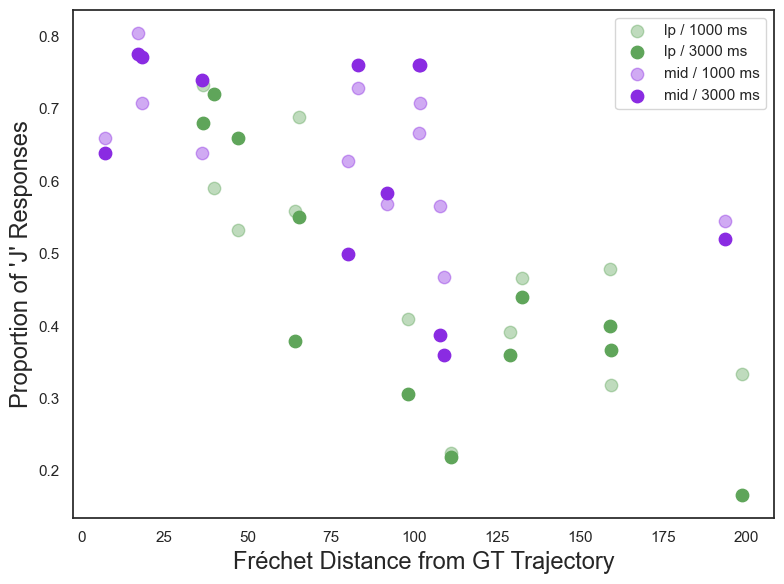

In [ ]:
import matplotlib.pyplot as plt

alpha_map = {700: 0.4, 3000: 1.0}

fig, ax = plt.subplots(figsize=(8,6))

for ch in ['lp', 'mid']:
    # Subset
    df_ch = df_plot[df_plot['choice'] == ch]
    
    for tcond in [1000, 3000]:
        df_sub = df_ch[df_ch['timeLimit'] == tcond]
        if df_sub.empty:
            continue
        
        ax.scatter(
            df_sub['fd_sum'],
            df_sub['prop_j'],
            color=choice_edge_color[ch],
            alpha=alpha_map[tcond],
            s=80,
            label=f"{ch} / {tcond} ms",
            # edgecolor='black'
        )

ax.set_xlabel("Fréchet Distance from GT Trajectory", fontsize = 17)
ax.set_ylabel("Proportion of 'J' Responses", fontsize = 17)
# ax.set_title("Scatter: Fréchet Distance vs. 'J' Proportion")

# Deduplicate legend
# handles, labels = ax.get_legend_handles_labels()
# by_label = dict(zip(labels, handles))
ax.legend()

plt.tight_layout()
plt.show()

#### Analysis 4 Logistic Regression & Model Comparisons (comparing only mid with lp: lp as reference and euclidean dis <= 125)

In [134]:
# Reverse encode response: 'j' -> 0, 'f' -> 1
df_all['response_numeric'] = df_all['response'].map({'j': 1, 'f': 0})

# Ensure categorical variables are properly handled
df_all['choice'] = df_all['choice'].astype('category')
df_all['subject_id'] = df_all['subject_id'].astype('category')
df_all['stimulus_idx'] = df_all['stimulus_idx'].astype('category')

df_all['dist_from_gt'] = np.sqrt(
    (df_all['obstacle_choice_x'] - df_all['obstacle_groundTruth_x']) ** 2 
  + (df_all['obstacle_choice_y'] - df_all['obstacle_groundTruth_y']) ** 2
)

In [135]:
df_all

,participant_ID,currentTrial,subject_id,study_id,session_id,rt,response,task,ball_X,obstacle_groundTruth_x,...,choice,timeLimit,obstacle_choice_x,obstacle_choice_y,ball_X_final,obstacle_groundTruth_x_final,obstacle_choice_x_final,is_accurate,response_numeric,dist_from_gt
0,6762abbea62dc4c2acf59fe0_result,1.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,487.0,j,ballFalling,604.4,650.021143,...,mid,3000.0,605.400000,300.000000,395.6,349.978857,394.600000,False,1,113.701464
1,6762abbea62dc4c2acf59fe0_result,2.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,814.0,j,ballFalling,604.4,650.021143,...,gt,3000.0,650.021143,404.580000,395.6,349.978857,349.978857,True,1,0.000000
2,6762abbea62dc4c2acf59fe0_result,3.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,1197.0,f,ballFalling,604.4,667.621143,...,gt,3000.0,667.621143,201.780000,604.4,667.621143,667.621143,False,0,0.000000
3,6762abbea62dc4c2acf59fe0_result,4.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,1033.0,j,ballFalling,322.3,296.071143,...,lp,3000.0,321.300000,287.332710,322.3,296.071143,321.300000,False,1,87.828789
4,6762abbea62dc4c2acf59fe0_result,5.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,903.0,f,ballFalling,500.0,453.671143,...,mid,3000.0,499.000000,300.000000,500.0,546.328857,501.000000,True,0,100.475938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2731,62a36469aa54a53fcfcc27d2_result,140.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,2086.0,j,ballFalling,604.4,650.021143,...,mid,3000.0,605.400000,300.000000,395.6,349.978857,394.600000,False,1,113.701464
2732,62a36469aa54a53fcfcc27d2_result,141.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,2185.0,f,ballFalling,500.0,453.671143,...,gt,3000.0,453.671143,210.330000,500.0,546.328857,546.328857,False,0,0.000000
2733,62a36469aa54a53fcfcc27d2_result,142.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,1684.0,f,ballFalling,604.4,650.021143,...,lp,3000.0,605.400000,372.634097,395.6,349.978857,394.600000,True,0,54.877929
2734,62a36469aa54a53fcfcc27d2_result,143.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,2182.0,j,ballFalling,604.4,596.871143,...,mid,3000.0,536.428857,300.000000,395.6,403.128857,463.571143,False,1,112.176290


In [136]:
df_mid_lp = df_all[df_all['choice'].isin(['mid', 'lp'])]
df_mid_lp['choice'] = pd.Categorical(df_mid_lp['choice'], categories=['lp', 'mid'])

In [137]:
df_mid_lp

,participant_ID,currentTrial,subject_id,study_id,session_id,rt,response,task,ball_X,obstacle_groundTruth_x,...,choice,timeLimit,obstacle_choice_x,obstacle_choice_y,ball_X_final,obstacle_groundTruth_x_final,obstacle_choice_x_final,is_accurate,response_numeric,dist_from_gt
0,6762abbea62dc4c2acf59fe0_result,1.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,487.0,j,ballFalling,604.4,650.021143,...,mid,3000.0,605.400000,300.000000,395.6,349.978857,394.600000,False,1,113.701464
3,6762abbea62dc4c2acf59fe0_result,4.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,1033.0,j,ballFalling,322.3,296.071143,...,lp,3000.0,321.300000,287.332710,322.3,296.071143,321.300000,False,1,87.828789
4,6762abbea62dc4c2acf59fe0_result,5.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,903.0,f,ballFalling,500.0,453.671143,...,mid,3000.0,499.000000,300.000000,500.0,546.328857,501.000000,True,0,100.475938
5,6762abbea62dc4c2acf59fe0_result,6.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,1159.0,f,ballFalling,500.0,510.871143,...,lp,3000.0,501.000000,151.000000,500.0,510.871143,501.000000,True,0,218.253340
6,6762abbea62dc4c2acf59fe0_result,7.0,6762abbea62dc4c2acf59fe0,6796e1c0ff24ca17c453c51c,67c715ba04b522cea8f2ad0a,880.0,f,ballFalling,500.0,479.921143,...,lp,3000.0,499.000000,189.929098,500.0,520.078857,501.000000,True,0,142.226371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2727,62a36469aa54a53fcfcc27d2_result,136.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,1615.0,f,ballFalling,604.4,596.871143,...,lp,3000.0,603.400000,215.502144,604.4,596.871143,603.400000,True,0,179.116885
2728,62a36469aa54a53fcfcc27d2_result,137.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,1566.0,f,ballFalling,604.4,667.621143,...,lp,3000.0,605.400000,151.000000,395.6,332.378857,394.600000,True,0,80.312384
2731,62a36469aa54a53fcfcc27d2_result,140.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,2086.0,j,ballFalling,604.4,650.021143,...,mid,3000.0,605.400000,300.000000,395.6,349.978857,394.600000,False,1,113.701464
2733,62a36469aa54a53fcfcc27d2_result,142.0,62a36469aa54a53fcfcc27d2,6796e1c0ff24ca17c453c51c,67c70c37ba4882acb9fcaeef,1684.0,f,ballFalling,604.4,650.021143,...,lp,3000.0,605.400000,372.634097,395.6,349.978857,394.600000,True,0,54.877929


In [ ]:
import bambi as bmb
import arviz as az

# Model 1: Full interaction: dist_from_gt + choice * timeLimit + random intercept per subject
formula_1 = "response_numeric ~ dist_from_gt + choice*C(timeLimit) + (1|subject_id)"
model_1 = bmb.Model(formula_1, df_mid_lp, family="bernoulli")
results_1 = model_1.fit(draws=1500, chains=6, cores=4, idata_kwargs={"log_likelihood": True})  # <-- crucial for WAIC/LOO)

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [Intercept, dist_from_gt, choice, C(timeLimit), choice:C(timeLimit), 1|subject_id_sigma, 1|subject_id_offset]


Sampling 6 chains for 1_000 tune and 1_500 draw iterations (6_000 + 9_000 draws total) took 561 seconds.


TypeError: 'bool' object is not iterable

In [ ]:
# Summarize
# print(az.summary(results_1))
# az.plot_posterior(results_1)

In [ ]:
formula_2 = "response_numeric ~ dist_from_gt + choice + C(timeLimit) + (1|subject_id)"

model_2 = bmb.Model(formula_2, df_mid_lp, family="bernoulli")
results_2 = model_2.fit(draws=1500, chains=6, cores=4, idata_kwargs={"log_likelihood": True, "posterior_predictive": True})

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [Intercept, dist_from_gt, choice, C(timeLimit), 1|subject_id_sigma, 1|subject_id_offset]


Sampling 6 chains for 1_000 tune and 1_500 draw iterations (6_000 + 9_000 draws total) took 23 seconds.


In [53]:
results_2

Inference data with groups:
	> posterior
	> log_likelihood
	> sample_stats
	> observed_data

In [54]:
formula_3 = "response_numeric ~ dist_from_gt + C(timeLimit) + (1|subject_id)"

model_3 = bmb.Model(formula_3, df_mid_lp, family="bernoulli")
results_3 = model_3.fit(draws=1500, chains=6, cores=4, idata_kwargs={"log_likelihood": True})

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [Intercept, dist_from_gt, C(timeLimit), 1|subject_id_sigma, 1|subject_id_offset]


Sampling 6 chains for 1_000 tune and 1_500 draw iterations (6_000 + 9_000 draws total) took 128 seconds.


In [55]:
# Model 4: No timeLimit effect: dist_from_gt + choice + random intercept
formula_4 = "response_numeric ~ dist_from_gt + choice + (1|subject_id)"
model_4 = bmb.Model(formula_4, df_mid_lp, family="bernoulli")
results_4 = model_4.fit(draws=1500, chains=6, cores=4, idata_kwargs={"log_likelihood": True})

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [Intercept, dist_from_gt, choice, 1|subject_id_sigma, 1|subject_id_offset]


Sampling 6 chains for 1_000 tune and 1_500 draw iterations (6_000 + 9_000 draws total) took 126 seconds.


                                         mean     sd  hdi_3%  hdi_97%  \
Intercept                               0.348  0.199  -0.020    0.728   
dist_from_gt                           -0.005  0.001  -0.007   -0.003   
choice[mid]                             0.665  0.096   0.490    0.845   
1|subject_id_sigma                      0.719  0.124   0.504    0.953   
1|subject_id[5980128635fbf100017d0861]  0.866  0.267   0.364    1.365   
1|subject_id[5e5dba9e3d60470d71dde9ef] -0.020  0.249  -0.476    0.454   
1|subject_id[5e648efca8c76520c918bb31] -0.084  0.247  -0.555    0.376   
1|subject_id[5f8f54c1450c2d1b5984c34f] -0.585  0.248  -1.060   -0.121   
1|subject_id[603f28793a28f30ab6932a12] -1.008  0.265  -1.488   -0.491   
1|subject_id[61bb392e40db417c1a138dcb]  1.457  0.303   0.902    2.037   
1|subject_id[65b929230cff388d15dd5c4c] -1.123  0.268  -1.643   -0.634   
1|subject_id[662692c1abc4830626fccb23] -0.792  0.260  -1.260   -0.290   
1|subject_id[6628591817056f60a12cb03b] -0.193  0.25

array([[<Axes: title={'center': 'Intercept'}>,
        <Axes: title={'center': 'dist_from_gt'}>,
        <Axes: title={'center': 'choice\nmid'}>,
        <Axes: title={'center': '1|subject_id_sigma'}>],
       [<Axes: title={'center': '1|subject_id\n5980128635fbf100017d0861'}>,
        <Axes: title={'center': '1|subject_id\n5e5dba9e3d60470d71dde9ef'}>,
        <Axes: title={'center': '1|subject_id\n5e648efca8c76520c918bb31'}>,
        <Axes: title={'center': '1|subject_id\n5f8f54c1450c2d1b5984c34f'}>],
       [<Axes: title={'center': '1|subject_id\n603f28793a28f30ab6932a12'}>,
        <Axes: title={'center': '1|subject_id\n61bb392e40db417c1a138dcb'}>,
        <Axes: title={'center': '1|subject_id\n65b929230cff388d15dd5c4c'}>,
        <Axes: title={'center': '1|subject_id\n662692c1abc4830626fccb23'}>],
       [<Axes: title={'center': '1|subject_id\n6628591817056f60a12cb03b'}>,
        <Axes: title={'center': '1|subject_id\n66358a8c455c8ca13957e2ca'}>,
        <Axes: title={'center': '1|

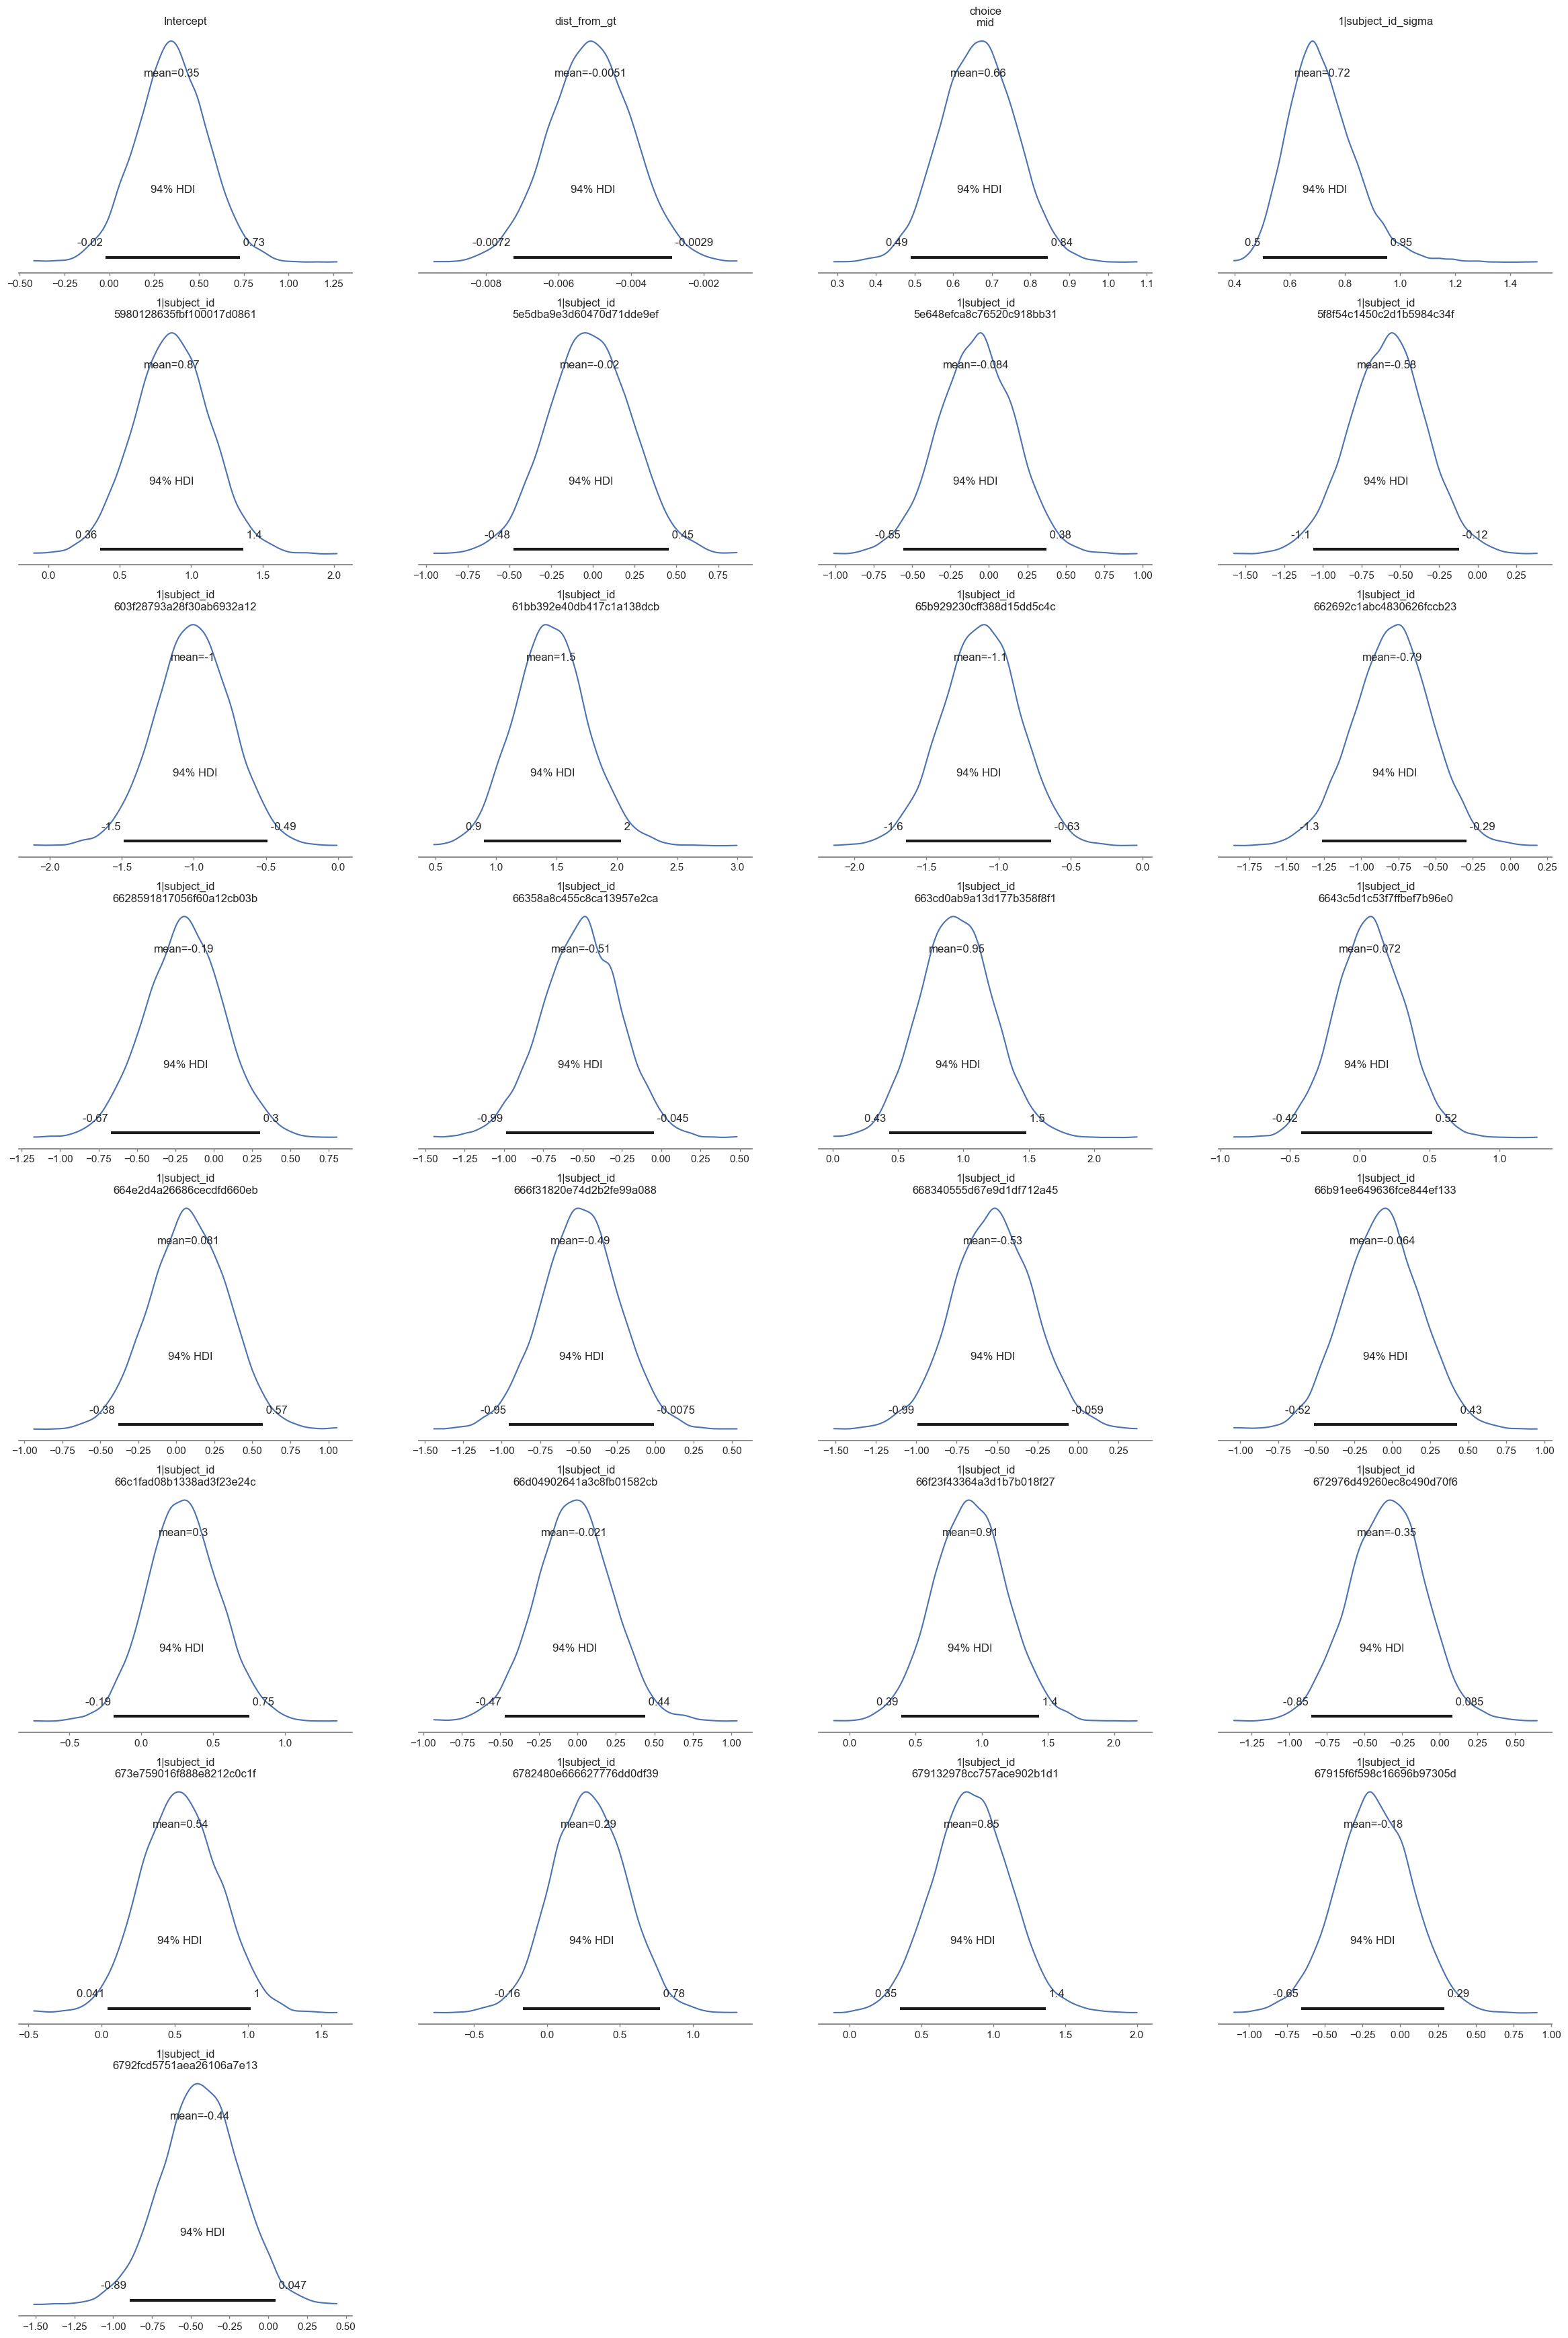

In [94]:
# Summarize
print(az.summary(results_4))
az.plot_posterior(results_4)

In [56]:
# Model 5: Distance only: dist_from_gt + random intercept
formula_5 = "response_numeric ~ dist_from_gt + (1|subject_id)"
model_5 = bmb.Model(formula_5, df_mid_lp, family="bernoulli")
results_5 = model_5.fit(draws=1500, chains=6, cores=4, idata_kwargs={"log_likelihood": True})

Modeling the probability that response_numeric==1
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (6 chains in 4 jobs)
NUTS: [Intercept, dist_from_gt, 1|subject_id_sigma, 1|subject_id_offset]


Sampling 6 chains for 1_000 tune and 1_500 draw iterations (6_000 + 9_000 draws total) took 31 seconds.


In [ ]:
# -------------------------------
# 3. Compare the Models
# -------------------------------

# Create a dictionary of the fitted models
model_dict = {
    "Model1_FullInteraction": results_1,
    "Model2_MainEffects": results_2,
    "Model3_NoChoice": results_3,
    "Model4_NoTimeLimit": results_4,
    "Model5_DistanceOnly": results_5,
}

# Compare models using WAIC
comp_waic = az.compare(model_dict, ic="waic")
print("Model Comparison using WAIC:")
print(comp_waic)

# Alternatively, compare models using LOO
comp_loo = az.compare(model_dict, ic="loo")
print("\nModel Comparison using LOO:")
print(comp_loo)

# model 4 is the best model: when the choice is further away from the gt, less likely to accept the choice;
# when the choice is mid, more likely to accept the choice

Model Comparison using WAIC:
                        rank    elpd_waic     p_waic  elpd_diff        weight  \
Model4_NoTimeLimit         0 -1435.922014  24.809225   0.000000  7.036974e-01   
Model2_MainEffects         1 -1436.187160  25.658476   0.265146  2.736321e-01   
Model1_FullInteraction     2 -1437.165829  26.835763   1.243815  3.807894e-16   
Model5_DistanceOnly        3 -1459.544454  23.751182  23.622440  2.267046e-02   
Model3_NoChoice            4 -1459.997823  24.865928  24.075809  0.000000e+00   

                               se       dse  warning scale  
Model4_NoTimeLimit      16.625578  0.000000    False   log  
Model2_MainEffects      16.703974  1.073929    False   log  
Model1_FullInteraction  16.741374  1.185176    False   log  
Model5_DistanceOnly     15.155267  6.991545    False   log  
Model3_NoChoice         15.254452  7.076792    False   log  

Model Comparison using LOO:
                        rank     elpd_loo      p_loo  elpd_diff   weight  \
Model4_NoTime

### Subset, euclidean distance <= 125

In [101]:
df_mid_lp = df_mid_lp[df_mid_lp['choice'].isin(['mid', 'lp'])]
df_sub = df_mid_lp[df_mid_lp['dist_from_gt'] < 1000]

In [102]:
df_sub

,participant_ID,currentTrial,subject_id,study_id,session_id,rt,response,task,ball_X,obstacle_groundTruth_x,...,choice,timeLimit,obstacle_choice_x,obstacle_choice_y,ball_X_final,obstacle_groundTruth_x_final,obstacle_choice_x_final,is_accurate,response_numeric,dist_from_gt
0,668340555d67e9d1df712a45_result,1.0,668340555d67e9d1df712a45,6790928bebf0b969fc839b02,679826202b2114cc04234446,846.0,f,ballFalling,500.0,510.871143,...,lp,1000.0,501.000000,151.0,500.0,489.128857,499.000000,True,0,218.253340
3,668340555d67e9d1df712a45_result,4.0,668340555d67e9d1df712a45,6790928bebf0b969fc839b02,679826202b2114cc04234446,774.0,f,ballFalling,604.4,575.421143,...,mid,1000.0,536.428857,300.0,604.4,575.421143,536.428857,True,0,51.237642
5,668340555d67e9d1df712a45_result,6.0,668340555d67e9d1df712a45,6790928bebf0b969fc839b02,679826202b2114cc04234446,784.0,j,ballFalling,604.4,650.021143,...,mid,1000.0,605.400000,300.0,604.4,650.021143,605.400000,False,1,113.701464
10,668340555d67e9d1df712a45_result,11.0,668340555d67e9d1df712a45,6790928bebf0b969fc839b02,679826202b2114cc04234446,598.0,j,ballFalling,604.4,667.621143,...,mid,1000.0,605.400000,300.0,395.6,332.378857,394.600000,False,1,116.269682
11,668340555d67e9d1df712a45_result,12.0,668340555d67e9d1df712a45,6790928bebf0b969fc839b02,679826202b2114cc04234446,556.0,f,ballFalling,500.0,453.671143,...,lp,1000.0,499.000000,151.0,500.0,453.671143,499.000000,True,0,74.664276
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3590,65b929230cff388d15dd5c4c_result,135.0,65b929230cff388d15dd5c4c,6790928bebf0b969fc839b02,6792bc7bd8cdd9caa5103fc3,765.0,f,ballFalling,604.4,667.621143,...,lp,1000.0,605.400000,151.0,395.6,332.378857,394.600000,True,0,80.312384
3592,65b929230cff388d15dd5c4c_result,137.0,65b929230cff388d15dd5c4c,6790928bebf0b969fc839b02,6792bc7bd8cdd9caa5103fc3,822.0,f,ballFalling,322.3,308.071143,...,mid,1000.0,321.300000,300.0,322.3,308.071143,321.300000,True,0,47.970144
3595,65b929230cff388d15dd5c4c_result,140.0,65b929230cff388d15dd5c4c,6790928bebf0b969fc839b02,6792bc7bd8cdd9caa5103fc3,853.0,j,ballFalling,322.3,379.371143,...,mid,1000.0,390.271143,300.0,322.3,379.371143,390.271143,False,1,55.824479
3598,65b929230cff388d15dd5c4c_result,143.0,65b929230cff388d15dd5c4c,6790928bebf0b969fc839b02,6792bc7bd8cdd9caa5103fc3,784.0,f,ballFalling,604.4,575.421143,...,lp,1000.0,603.400000,151.0,395.6,424.578857,396.600000,True,0,119.093216


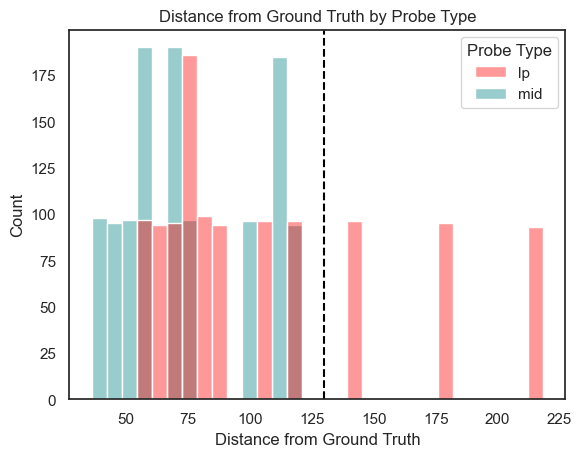

In [120]:
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Create the histogram with an automatic legend
histplot = sns.histplot(
    data=df_sub, 
    x="dist_from_gt", 
    hue="choice",       
    fill=True,
    common_norm=False,
    alpha=0.4,
    palette={"lp": "red", "mid": "teal"},  # <-- Custom palette
    bins=30,
    ax=ax
)

ax.set_xlabel("Distance from Ground Truth")
ax.set_ylabel("Count")
ax.set_title("Distance from Ground Truth by Probe Type")
plt.axvline(x=130, color='black', linestyle='--', linewidth=1.5)
# Get the legend object that Seaborn created
legend = ax.get_legend()

# Update the legend title
if legend is not None:
    legend.set_title("Probe Type")

plt.show()